# Multi Task Learning: using VGGFace weights and Gender Feature Embedding for Age Group and Race Classification along with Gender Classification


## 1. Dataset

In [ ]:
!pip install keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 39.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import cv2
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, losses
from keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import set_random_seed
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import keras_cv
from keras.utils import plot_model

from tensorflow import keras
from tensorflow.keras.callbacks import Callback

In [ ]:
# Setting the seed
seed = 42
set_random_seed(seed)
np.random.seed(42)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
folder_path = "/content/drive/My Drive/UTKFace_retina_cropped_100x100"

In [ ]:
cnt = 0
for file in sorted(os.listdir(folder_path)):  # Sort file list
  file_path = os.path.join(folder_path,file)
  cnt = cnt + 1

print(f"Number of face images: {cnt}")

Number of face images: 23561


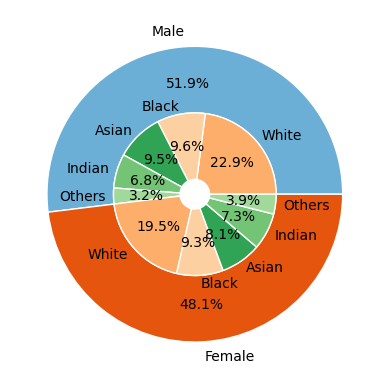

In [ ]:
# age: is an integer from 0 to 116, indicating the age
# gender: is either 0 (male) or 1 (female)
# race: is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).

column_names = ['Age', 'Gender', 'Race']
records = []

for file in os.listdir(folder_path):
  records.append(file.split('_')[:-1])

DFrame=pd.DataFrame(records, columns=column_names).astype(int)

# EDA: Pie chart:
fig, ax = plt.subplots()
cmap = plt.colormaps["tab20c"]
outer_colors = cmap([1,4])
inner_colors = cmap([6,7,8,9,10, 6,7,8,9,10])
size = 0.45
pctdist = 0.75

DF_tot = DFrame['Gender'].value_counts()

# Outer pie chart
ax.pie(
    np.array(DF_tot),
    autopct='%1.1f%%',
    pctdistance = pctdist,
    radius=1.0,
    colors=outer_colors,
    wedgeprops=dict(width=size, edgecolor='w'),
    labels=['Male', 'Female']    #[0, 1]
);

# Counts of races in females
DF_F = DFrame.Race[DFrame['Gender']==1].value_counts()

# Counts of races in males
DF_M = DFrame.Race[DFrame['Gender']==0].value_counts()

# Concatenate arrays, for use in inner pie chart
concat_arrays= np.concatenate((np.array(DF_M), np.array(DF_F)))  #T, F

# Inner pie chart (to show sub-distribution of "race")
ax.pie(
    concat_arrays,
    autopct='%1.1f%%',
    radius=1.0-size,
    colors=inner_colors,
    wedgeprops=dict(width=size, edgecolor='w'),
    labels=['White','Black','Asian','Indian', 'Others',
            'White','Black','Asian','Indian', 'Others',]
);

Text(0.5, 1.0, 'Distribution of race in the UTKFace dataset')

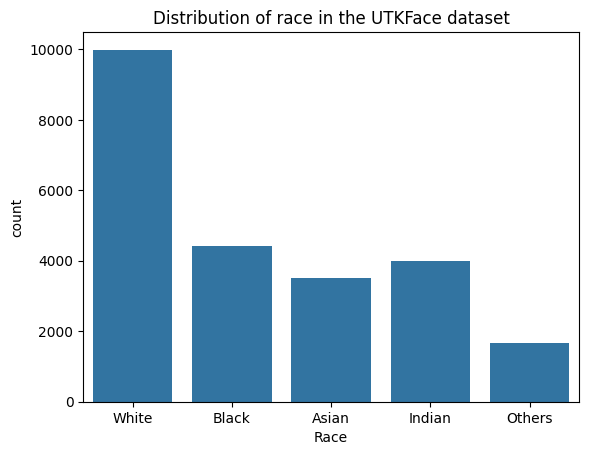

In [ ]:
# Race Mapping
race_mapping = {
    0 : 'White',
    1 : 'Black',
    2 : 'Asian',
    3 : 'Indian',
    4 : 'Others'
}

# Replace the integers with correct race
DFrame['Race'] = DFrame['Race'].replace(race_mapping)

# Specify the order of categories based on race_mapping
race_order = list(race_mapping.values())

# Count plot
plt.figure()
sns.countplot(x='Race', data=DFrame, order=race_order)
plt.title('Distribution of race in the UTKFace dataset')

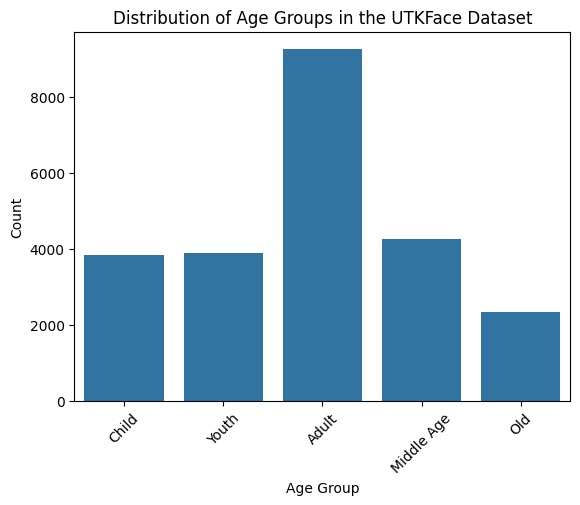

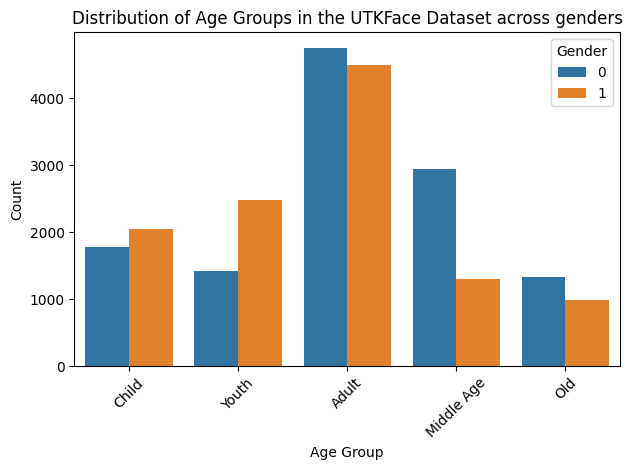

In [ ]:
# Age distribution

# Define bins and labels
bins = [0, 14, 25, 40, 60, 116]
labels = ["Child", "Youth", "Adult", "Middle Age", "Old"]

# Classify ages into groups
DFrame['Age_Group'] = pd.cut(DFrame['Age'], bins=bins, labels=labels, right=True)  # (0, 14], (14,25], (25, 40],...

# Plot the distribution of age groups
fig1, ax1 = plt.subplots()
sns.countplot(x='Age_Group', data=DFrame, ax=ax1)
ax1.set_title('Distribution of Age Groups in the UTKFace Dataset')
ax1.set_xlabel('Age Group')
ax1.set_ylabel('Count')


# Plot the distribution of age groups with gender
fig1, ax2 = plt.subplots()
sns.countplot(x='Age_Group', hue='Gender', data=DFrame, ax=ax2)
ax2.set_title('Distribution of Age Groups in the UTKFace Dataset across genders')
ax2.set_xlabel('Age Group')
ax2.set_ylabel('Count')

# Rotate x-tick labels for both axes
for label in ax1.get_xticklabels():
  label.set_rotation(45)  # Rotate x-tick labels by 45 degrees

for label in ax2.get_xticklabels():
  label.set_rotation(45)  # Rotate x-tick labels by 45 degrees

plt.tight_layout()
plt.show()

In [ ]:
def labeling_age_group_tf(age, bins):
    # Convert bins and age to TensorFlow constants
    bins = tf.constant(bins, dtype=tf.int32)

    # Create labels from 0 to len(bins) - 2
    age_groups = tf.range(len(bins) - 1, dtype=tf.int32)

    # Find the appropriate age group using TensorFlow ops
    conditions = tf.logical_and(age > bins[:-1], age <= bins[1:])
    label = tf.reduce_sum(tf.where(conditions, age_groups, 0))

    return label

In [ ]:
def read_image(fname):
    # Extract label from file name
    parts = tf.strings.split(fname, os.sep)
    file_name = parts[-1]
    multiple_labels = tf.strings.split(file_name, '_')

    # Convert age label to integer
    age_label = tf.strings.to_number(multiple_labels[0], out_type=tf.int32)

    # Define age bins
    bins = [0, 14, 25, 40, 60, 116]

    # Extract labels (age, gender, race)
    age_label =  labeling_age_group_tf(age_label, bins)  # First part: age
    gender_label = tf.strings.to_number(multiple_labels[1], out_type=tf.int32)     # Second part: gender
    race_label = tf.strings.to_number(multiple_labels[2], out_type=tf.int32)       # Third part: race

    # Convert race label to integer
    label = tf.strings.to_number(multiple_labels[2], out_type=tf.int32)

    # Load and decode the image
    image = tf.io.read_file(fname)
    image = tf.io.decode_jpeg(image)
    return image, age_label, gender_label, race_label

In [ ]:
# Define the rotation layer outside the function for reuse
rotation_layer = keras_cv.layers.RandomRotation(factor=0.111)  # 0.111 ~= 20 degrees

# RGB mean values to subtract

mean_vector = [91.4953, 103.8827, 131.0912]

def preprocess_image(image, age_label, gender_label, race_label, augment=False, mean_vector=mean_vector):
    # Convert image to float32 and normalize to [0,1] if not already done in the dataset pipeline
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)

    if augment:
        # Apply augmentation
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
        image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
        image = tf.image.random_hue(image, max_delta=0.05)

        # Rotate up to 20 degrees using KerasCV
        image = rotation_layer(image)

    # Subtract RGB mean values
    mean_values = tf.constant(mean_vector, dtype=tf.float32)
    image = image - mean_values / 255.0  # Normalize mean values to [0,1] scale

    return image, age_label, gender_label, race_label

In [ ]:
# Creating training, validation and test sets...
list_ds = tf.data.Dataset.list_files(folder_path + "/*")

# Total number of files
file_count = len(list_ds)

# Define split sizes
train_size = int(0.8 * file_count)  # 80% for training
val_size = int(0.1 * file_count)    # 10% for validation
test_size = file_count - train_size - val_size  # Remaining 10% for testing

# Shuffle the dataset before splitting
list_ds = list_ds.shuffle(buffer_size=file_count, seed=42)

# Split into training, validation, and test datasets
train_list_ds = list_ds.take(train_size)  # First 80% for training
val_list_ds = list_ds.skip(train_size).take(val_size)  # Next 10% for validation
test_list_ds = list_ds.skip(train_size + val_size)  # Remaining 10% for test

# for element in list_ds.as_numpy_iterator():
#   print(element)
#   break

In [ ]:
batch_size = 128

# Updated dataset preparation with preprocessing
train_ds = (
    train_list_ds
    .map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    .map(lambda img, age_lbl, gender_lbl, race_lbl:
         preprocess_image(img, age_lbl, gender_lbl, race_lbl, augment=False),  # Don't apply preprocessing with augmentation
         num_parallel_calls=tf.data.AUTOTUNE)
    .map(lambda img, age_lbl, gender_lbl, race_lbl:
         (img, {'age_output': age_lbl, 'gender_output': gender_lbl, 'race_output': race_lbl}),  # Format the labels
         num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    val_list_ds
    .map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    .map(lambda img, age_lbl, gender_lbl, race_lbl:
         preprocess_image(img, age_lbl, gender_lbl, race_lbl, augment=False),  # Apply preprocessing without augmentation
         num_parallel_calls=tf.data.AUTOTUNE)
    .map(lambda img, age_lbl, gender_lbl, race_lbl:
         (img, {'age_output': age_lbl, 'gender_output': gender_lbl, 'race_output': race_lbl}),  # Format the labels
         num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    test_list_ds
    .map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    .map(lambda img, age_lbl, gender_lbl, race_lbl:
         preprocess_image(img, age_lbl, gender_lbl, race_lbl, augment=False),  # Apply preprocessing without augmentation
         num_parallel_calls=tf.data.AUTOTUNE)
    .map(lambda img, age_lbl, gender_lbl, race_lbl:
         (img, {'age_output': age_lbl, 'gender_output': gender_lbl, 'race_output': race_lbl}),  # Format the labels
         num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)


In [ ]:
# Example check
for img, labels in train_ds.take(1):  # Take one batch
    print("Image shape:", img.shape)  # Print image shape
    print("Labels dictionary:", labels)  # Print labels dictionary

    # Access individual labels
    age_lbl = labels['age_output']
    gender_lbl = labels['gender_output']
    race_lbl = labels['race_output']

    print("Age labels:", age_lbl.numpy())
    print("Gender labels:", gender_lbl.numpy())
    print("Race labels:", race_lbl.numpy())


Image shape: (128, 100, 100, 3)
Labels dictionary: {'age_output': <tf.Tensor: shape=(128,), dtype=int32, numpy=
array([3, 2, 3, 2, 3, 0, 4, 2, 3, 0, 0, 2, 2, 1, 3, 4, 2, 4, 2, 3, 2, 3,
       3, 4, 2, 1, 2, 2, 1, 2, 2, 3, 2, 2, 2, 1, 3, 1, 3, 1, 2, 0, 4, 4,
       1, 2, 2, 1, 2, 3, 2, 4, 2, 1, 2, 3, 1, 3, 2, 2, 2, 3, 0, 2, 2, 2,
       3, 4, 2, 0, 3, 4, 0, 1, 3, 2, 2, 2, 2, 1, 2, 3, 3, 3, 2, 2, 2, 3,
       2, 2, 1, 1, 2, 3, 2, 3, 2, 3, 3, 0, 2, 2, 2, 0, 2, 1, 2, 1, 3, 0,
       3, 2, 0, 3, 3, 1, 4, 2, 4, 2, 2, 2, 3, 3, 2, 3, 3, 4], dtype=int32)>, 'gender_output': <tf.Tensor: shape=(128,), dtype=int32, numpy=
array([0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0,

In [ ]:
def unpreprocess_image(image, mean_vector=mean_vector):
  mean_values = tf.constant(mean_vector, dtype=tf.float32)
  image = image + mean_values / 255.0
  return image

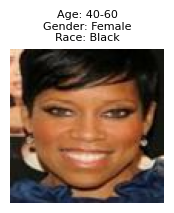

Age Label: 40-60, Age Integer: 3
Gender Label: Female, Gender Integer: 1
Race Label: Black, Race Integer: 1


In [ ]:
# Define label names for the tasks
age_labels = ["0-14", "14-25", "25-40", "40-60", "60+"]
gender_labels = ["Male", "Female"]
race_labels = ["White", "Black", "Asian", "Indian", "Others"]

img_no = 0

# Loop through the dataset to extract and visualize one example
for img, labels in train_ds.take(1):
    img0 = img[img_no]

    # Unpack individual labels
    age_int_labels = labels['age_output']
    gender_int_labels = labels['gender_output']
    race_int_labels = labels['race_output']

    age_label = age_labels[age_int_labels[img_no]]
    gender_label = gender_labels[gender_int_labels[img_no]]
    race_label = race_labels[race_int_labels[img_no]]

    # Display the image with the labels
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.imshow(unpreprocess_image(img0))
    ax.axis('off')
    ax.set_title(f"Age: {age_label}\nGender: {gender_label}\nRace: {race_label}", fontsize=8)
    plt.show()

    # Print detailed information
    print(f"Age Label: {age_label}, Age Integer: {age_int_labels[img_no]}")
    print(f"Gender Label: {gender_label}, Gender Integer: {gender_int_labels[img_no]}")
    print(f"Race Label: {race_label}, Race Integer: {race_int_labels[img_no]}")


    img_no = img_no + 1
    if img_no == batch_size:
       img_no = 0
    # Break after first example
    break

## 2. Building a CNN using Transfer Learning on VGG16
Input image shape: (100, 100, 3)

Let's include VGG16 model without the top

In [ ]:

img_input = layers.Input((100, 100, 3), dtype='float32', name='base_model')
# Block 1
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_1')(img_input)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_2')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(x)

# Block 2
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_2')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(x)

# Block 3
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_3')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(x)

# Block 4
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_2')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_3')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(x)

# Block 5
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_1')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_2')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_3')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool5')(x)

# Define the base model
base_model = models.Model(inputs=img_input, outputs=x, name='base_vgg_model')

#weights_path = 'https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_tf_notop_vgg16.h5'
# https://github.com/rcmalli/keras-vggface/tree/master


weights_path = "/content/drive/My Drive/VGGFace weights/rcmalli_vggface_tf_notop_vgg16.h5"
#https://github.com/rcmalli/keras-vggface/releases
base_model.load_weights(weights_path)

for layer in base_model.layers[:15]:      #for layer in base_model.layers[:15]:
    layer.trainable = False

# Task-specific heads

# Gender Classification Head
gender = layers.Reshape((-1,))(base_model.output)
gender = layers.Dense(128, activation='relu', name='gender_fc1')(gender)
gender_out = layers.Dense(2, activation='softmax', name='gender_output')(gender)


# Age Group Classification Head
age_group = layers.Reshape((-1,))(base_model.output)
# Concatenate gender and age_group features
gender_age = layers.Concatenate(name='concat_gender_age')([gender, age_group])
gender_age = layers.Dense(128, activation='relu', name='gender_age_fc1')(gender_age)
age_out = layers.Dense(5, activation='softmax', name='age_output')(gender_age)


# Race Classification Head
race = layers.Reshape((-1,))(base_model.output)
# Concatenate gender and race features
gender_race = layers.Concatenate(name='concat_gender_race')([gender, race])
gender_race = layers.Dense(128, activation='relu', name='gender_race_fc1')(gender_race)
race_out = layers.Dense(5, activation='softmax', name='race_output')(gender_race)

# Multi-task Model
model = models.Model(inputs=base_model.input, outputs=[age_out, gender_out, race_out], name='multi_task_model')

# Print the model summary
model.summary()


Model: "multi_task_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ base_model (InputLayer)   │ (None, 100, 100, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_1 (Conv2D)          │ (None, 100, 100, 64)   │          1,792 │ base_model[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_2 (Conv2D)          │ (None, 100, 100, 64)   │         36,928 │ conv1_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 50, 50, 64)     │              0 │ conv1_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_1 (Conv2D)          │ (None, 50, 50, 128)    │         73,856 │ pool1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_2 (Conv2D)          │ (None, 50, 50, 128)    │        147,584 │ conv2_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool2 (MaxPooling2D)      │ (None, 25, 25, 128)    │              0 │ conv2_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3_1 (Conv2D)          │ (None, 25, 25, 256)    │        295,168 │ pool2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3_2 (Conv2D)          │ (None, 25, 25, 256)    │        590,080 │ conv3_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3_3 (Conv2D)          │ (None, 25, 25, 256)    │        590,080 │ conv3_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool3 (MaxPooling2D)      │ (None, 12, 12, 256)    │              0 │ conv3_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv4_1 (Conv2D)          │ (None, 12, 12, 512)    │      1,180,160 │ pool3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv4_2 (Conv2D)          │ (None, 12, 12, 512)    │      2,359,808 │ conv4_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv4_3 (Conv2D)          │ (None, 12, 12, 512)    │      2,359,808 │ conv4_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool4 (MaxPooling2D)      │ (None, 6, 6, 512)      │              0 │ conv4_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv5_1 (Conv2D)          │ (None, 6, 6, 512)      │      2,359,808 │ pool4[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv5_2 (Conv2D)          │ (None, 6, 6, 512)      │      2,359,808 │ conv5_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv5_3 (Conv2D)          │ (None, 6, 6, 512)      │      2,359,808 │ conv5_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool5 (MaxPooling2D)      │ (None, 3, 3, 512)      │              0 │ conv5_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)    

 Total params: 16,518,860 (63.01 MB)

 Trainable params: 8,883,596 (33.89 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
# Print layer numbers and details
cnt = 1
for layer in base_model.layers:
    print(f'{cnt}: {layer.name} - {"Trainable" if layer.trainable else "Frozen"}')
    cnt += 1


1: base_model - Frozen
2: conv1_1 - Frozen
3: conv1_2 - Frozen
4: pool1 - Frozen
5: conv2_1 - Frozen
6: conv2_2 - Frozen
7: pool2 - Frozen
8: conv3_1 - Frozen
9: conv3_2 - Frozen
10: conv3_3 - Frozen
11: pool3 - Frozen
12: conv4_1 - Frozen
13: conv4_2 - Frozen
14: conv4_3 - Frozen
15: pool4 - Frozen
16: conv5_1 - Trainable
17: conv5_2 - Trainable
18: conv5_3 - Trainable
19: pool5 - Trainable


In [ ]:
# Print layer numbers and details
cnt = 1
for layer in model.layers:
    print(f'{cnt}: {layer.name} - {"Trainable" if layer.trainable else "Frozen"}')
    cnt += 1


1: base_model - Frozen
2: conv1_1 - Frozen
3: conv1_2 - Frozen
4: pool1 - Frozen
5: conv2_1 - Frozen
6: conv2_2 - Frozen
7: pool2 - Frozen
8: conv3_1 - Frozen
9: conv3_2 - Frozen
10: conv3_3 - Frozen
11: pool3 - Frozen
12: conv4_1 - Frozen
13: conv4_2 - Frozen
14: conv4_3 - Frozen
15: pool4 - Frozen
16: conv5_1 - Trainable
17: conv5_2 - Trainable
18: conv5_3 - Trainable
19: pool5 - Trainable
20: reshape - Trainable
21: gender_fc1 - Trainable
22: reshape_1 - Trainable
23: reshape_2 - Trainable
24: concat_gender_age - Trainable
25: concat_gender_race - Trainable
26: gender_age_fc1 - Trainable
27: gender_race_fc1 - Trainable
28: age_output - Trainable
29: gender_output - Trainable
30: race_output - Trainable


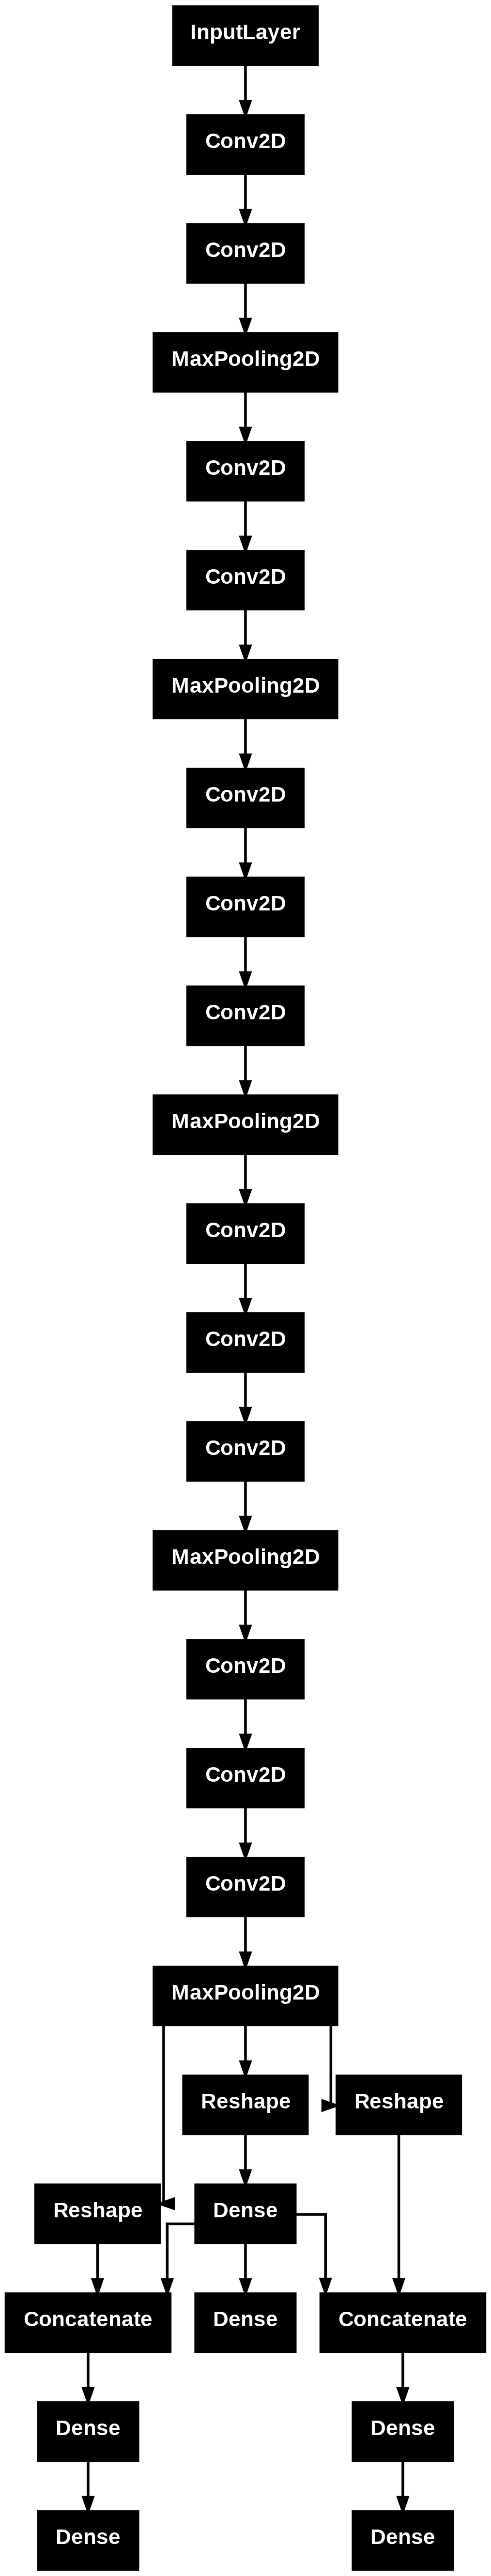

In [ ]:
plot_model(model)

In [ ]:
# class CombinedAccuracyCallback(keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs=None):
#     # Calculate combined accuracy
#     combined_val_accuracy = (
#         0.4 * logs.get('val_age_output_accuracy', 0) +
#         0.2 * logs.get('val_gender_output_accuracy', 0) +
#         0.4 * logs.get('val_race_output_accuracy', 0)
#     )

#     # Log it
#     print(f"\nEpoch {epoch + 1}: Combined Validation Accuracy = {combined_val_accuracy:.4f}")
#     logs['combined_val_accuracy'] = combined_val_accuracy

In [ ]:
class CombinedAccuracyCallback(keras.callbacks.Callback):
  def __init__(self, checkpoint_path):
    super().__init__()
    self.best_accuracy = 0  # Initialize the best accuracy as 0
    self.checkpoint_path = checkpoint_path  # Path to save the best model

  def on_epoch_end(self, epoch, logs=None):
    # Calculate combined validation accuracy
    combined_val_accuracy = (
        0.4 * logs.get('val_age_output_accuracy', 0) +
        0.2 * logs.get('val_gender_output_accuracy', 0) +
        0.4 * logs.get('val_race_output_accuracy', 0)
    )

    # Log combined validation accuracy
    print(f"\nEpoch {epoch + 1}: Combined Validation Accuracy = {combined_val_accuracy:.4f}")
    logs['combined_val_accuracy'] = combined_val_accuracy

    # Save the model if combined accuracy improves
    if combined_val_accuracy > self.best_accuracy:
      print(f"New best combined accuracy! Saving model to {self.checkpoint_path}")
      self.best_accuracy = combined_val_accuracy
      self.model.save(self.checkpoint_path)  # Save the model
    else:
      print("Combined accuracy did not improve.")


In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Define the checkpoint path in Google Drive
checkpoint_dir = '/content/drive/MyDrive/model_checkpoints/'

# Define the checkpoint path
checkpoint_path = os.path.join(checkpoint_dir, 'best_weights_30_3_v3.keras')

# Create the checkpoint callback
#mc_callback = ModelCheckpoint(filepath=checkpoint_path, monitor='combined_val_accuracy',
                              #save_best_only=True, mode='max')

combined_accuracy_callback = CombinedAccuracyCallback(checkpoint_path=checkpoint_path)

def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return lr * float(tf.math.exp(-0.01))

lr_callback = LearningRateScheduler(scheduler)

In [ ]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0),
    loss={
        'age_output': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        'gender_output': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        'race_output': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    },

    loss_weights={
        'age_output': 0.4,
        'gender_output': 0.2,
        'race_output': 0.4,
    },

    metrics={
        'age_output': ['accuracy'],
        'gender_output': ['accuracy'],
        'race_output': ['accuracy'],
    }
)
# My model’s last layer has a softmax activation, thus from_logits=False

In [ ]:
history = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    batch_size=batch_size,
    callbacks=[combined_accuracy_callback, lr_callback]
) #batch_size=128

Epoch 1/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - age_output_accuracy: 0.5275 - age_output_loss: 0.4526 - gender_output_accuracy: 0.7893 - gender_output_loss: 0.0882 - loss: 0.9895 - race_output_accuracy: 0.5734 - race_output_loss: 0.4487
Epoch 1: Combined Validation Accuracy = 0.7478
New best combined accuracy! Saving model to /content/drive/MyDrive/model_checkpoints/best_weights_30_3_v3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 110s 559ms/step - age_output_accuracy: 0.5279 - age_output_loss: 0.4522 - gender_output_accuracy: 0.7896 - gender_output_loss: 0.0881 - loss: 0.9885 - race_output_accuracy: 0.5739 - race_output_loss: 0.4482 - val_age_output_accuracy: 0.6549 - val_age_output_loss: 0.3242 - val_gender_output_accuracy: 0.8935 - val_gender_output_loss: 0.0512 - val_loss: 0.6445 - val_race_output_accuracy: 0.7678 - val_race_output_loss: 0.2719 - combined_val_accuracy: 0.7478 - learning_rate: 1.0000e-04
Epoch 2/30
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - age_output_accuracy: 0.66

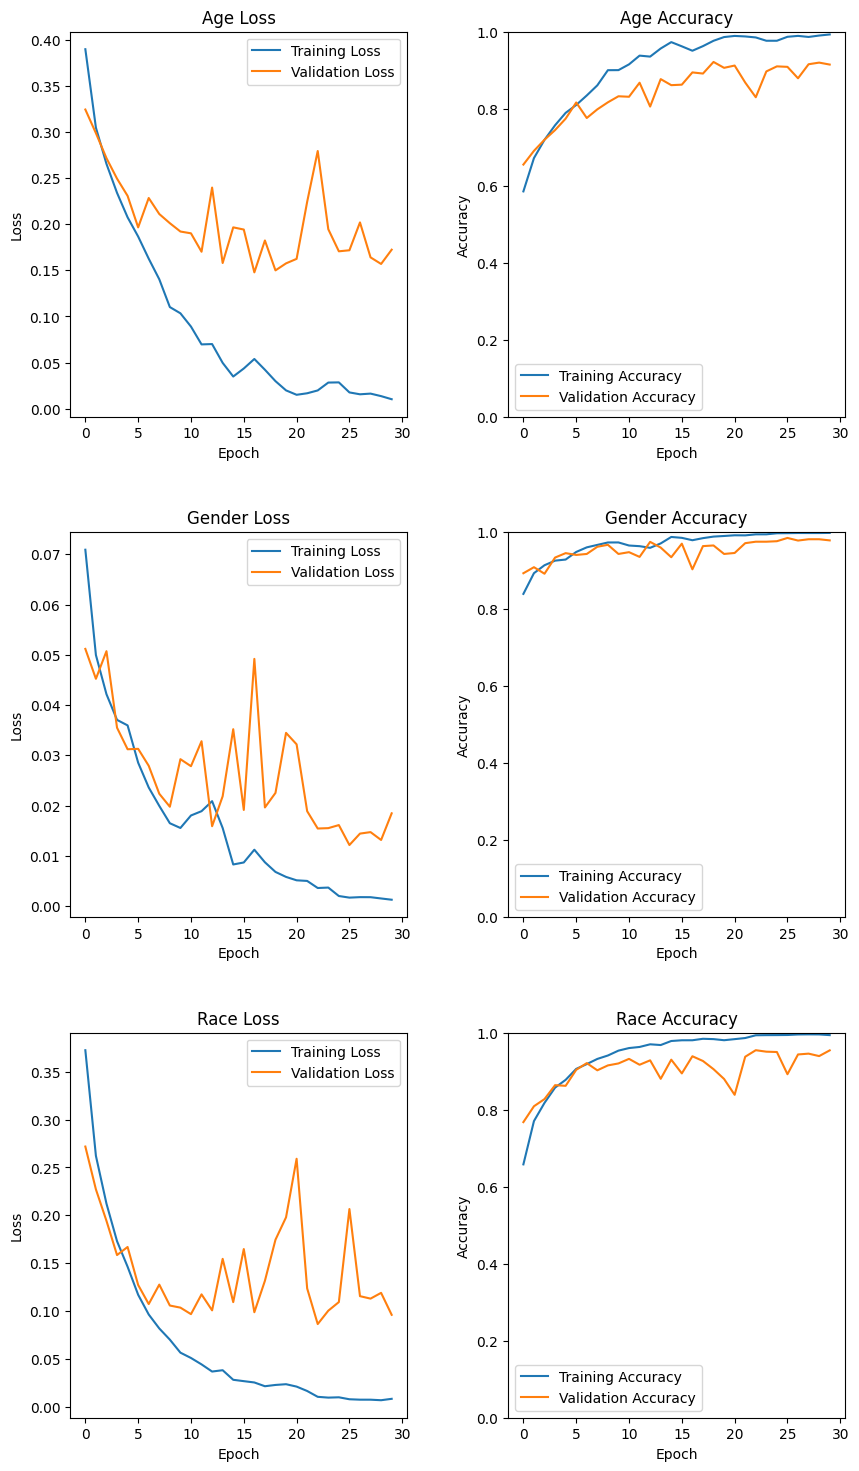

In [ ]:
# Extract task-specific data from history
gender_loss = history.history['gender_output_loss']
age_loss = history.history['age_output_loss']
race_loss = history.history['race_output_loss']

val_gender_loss = history.history['val_gender_output_loss']
val_age_loss = history.history['val_age_output_loss']
val_race_loss = history.history['val_race_output_loss']

gender_acc = history.history['gender_output_accuracy']
age_acc = history.history['age_output_accuracy']
race_acc = history.history['race_output_accuracy']

val_gender_acc = history.history['val_gender_output_accuracy']
val_age_acc = history.history['val_age_output_accuracy']
val_race_acc = history.history['val_race_output_accuracy']

# Plot Loss Curves
fig, axs = plt.subplots(3, 2, figsize=(10, 18))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Loss plots
axs[0, 0].plot(age_loss, label='Training Loss')
axs[0, 0].plot(val_age_loss, label='Validation Loss')
axs[0, 0].set_title('Age Loss')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()

axs[1, 0].plot(gender_loss, label='Training Loss')
axs[1, 0].plot(val_gender_loss, label='Validation Loss')
axs[1, 0].set_title('Gender Loss')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].legend()

axs[2, 0].plot(race_loss, label='Training Loss')
axs[2, 0].plot(val_race_loss, label='Validation Loss')
axs[2, 0].set_title('Race Loss')
axs[2, 0].set_xlabel('Epoch')
axs[2, 0].set_ylabel('Loss')
axs[2, 0].legend()

# Accuracy plots
axs[0, 1].plot(age_acc, label='Training Accuracy')
axs[0, 1].plot(val_age_acc, label='Validation Accuracy')
axs[0, 1].set_title('Age Accuracy')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].set_ylim([0, 1])
axs[0, 1].legend()

axs[1, 1].plot(gender_acc, label='Training Accuracy')
axs[1, 1].plot(val_gender_acc, label='Validation Accuracy')
axs[1, 1].set_title('Gender Accuracy')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].set_ylim([0, 1])
axs[1, 1].legend()

axs[2, 1].plot(race_acc, label='Training Accuracy')
axs[2, 1].plot(val_race_acc, label='Validation Accuracy')
axs[2, 1].set_title('Race Accuracy')
axs[2, 1].set_xlabel('Epoch')
axs[2, 1].set_ylabel('Accuracy')
axs[2, 1].set_ylim([0, 1])
axs[2, 1].legend()

plt.show()

### Evaluating the model

In [ ]:
# Load the weights of the model with the best validation accuracy
model.load_weights(checkpoint_path)

# Evaluate the model on the test dataset
evaluation_results = model.evaluate(test_ds, verbose=2)

# Extract and display the results for each task
print("")
print(f"Overall test loss = {np.round(evaluation_results[0], 4)}")

# Task-specific losses
age_loss = np.round(evaluation_results[1], 4)
gender_loss = np.round(evaluation_results[2], 4)
race_loss = np.round(evaluation_results[3], 4)
print(f"Age loss = {age_loss}")
print(f"Gender loss = {gender_loss}")
print(f"Race loss = {race_loss}")

# Task-specific accuracies (assuming 'accuracy' is the metric used)
age_acc = np.round(evaluation_results[4], 4)
gender_acc = np.round(evaluation_results[5], 4)
race_acc = np.round(evaluation_results[6], 4)
print(f"Age accuracy = {age_acc}")
print(f"Gender accuracy = {gender_acc}")
print(f"Race accuracy = {race_acc}")

19/19 - 16s - 836ms/step - age_output_accuracy: 0.9202 - age_output_loss: 0.1719 - gender_output_accuracy: 0.9784 - gender_output_loss: 0.0200 - loss: 0.3041 - race_output_accuracy: 0.9542 - race_output_loss: 0.1072

Overall test loss = 0.3041
Age loss = 0.1719
Gender loss = 0.02
Race loss = 0.1072
Age accuracy = 0.9202
Gender accuracy = 0.9784
Race accuracy = 0.9542


### Visualising some predictions made by VGG16 model

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step


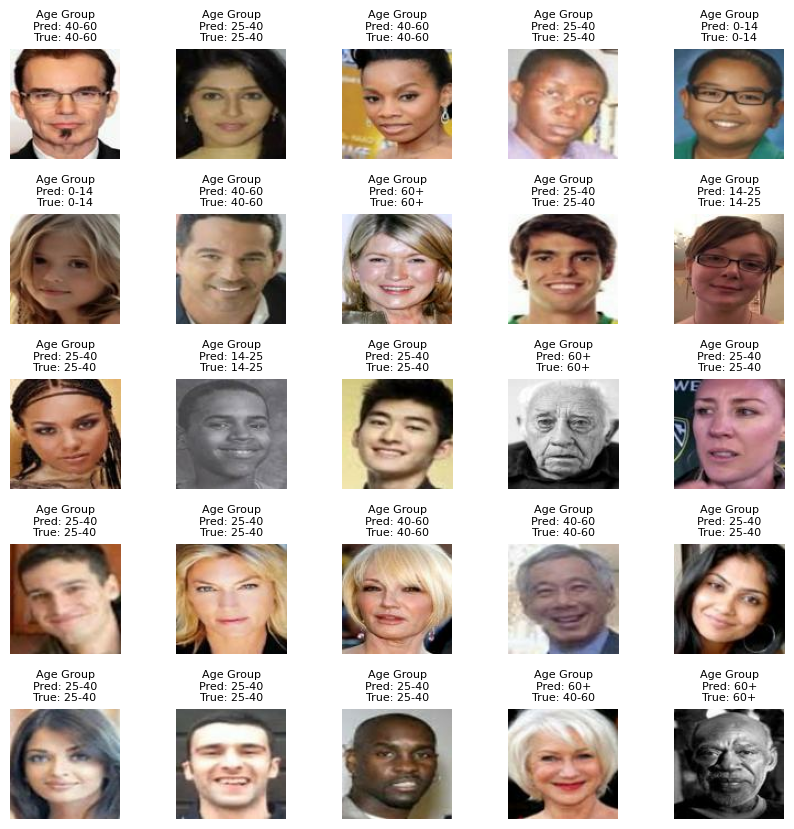

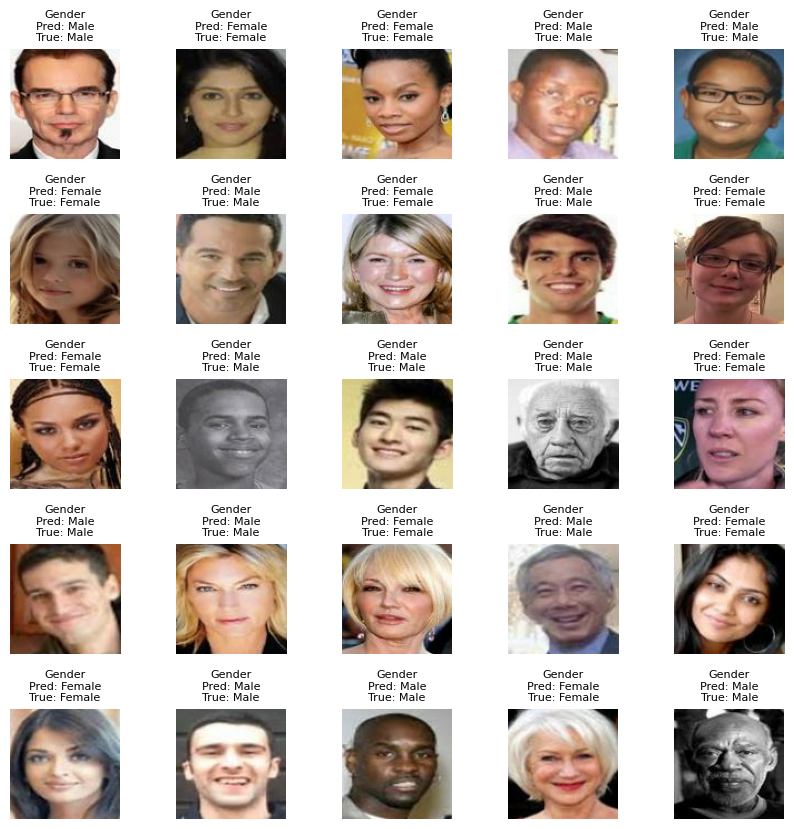

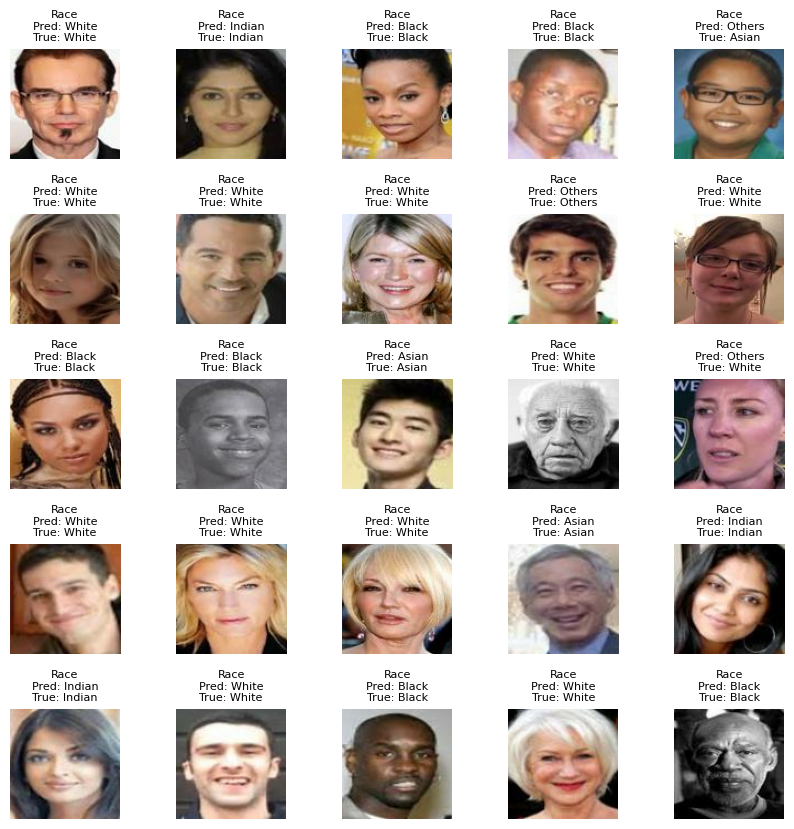

In [ ]:
# Function to reverse preprocessing
def unpreprocess_image(image, mean_vector=mean_vector):
    mean_values = tf.constant(mean_vector, dtype=tf.float32)
    image = image + mean_values / 255.0
    return image

# String labels for each task

age_labels = ["0-14", "14-25", "25-40", "40-60", "60+"]
gender_labels = ["Male", "Female"]
race_labels = ["White", "Black", "Asian", "Indian", "Others"]

# Get predictions for test data
predicted_scores = model.predict(test_ds)
predicted_age = np.argmax(predicted_scores[0], axis=1)
predicted_gender = np.argmax(predicted_scores[1], axis=1)
predicted_race = np.argmax(predicted_scores[2], axis=1)

# Initialize lists to store images and true labels for each task
true_age = []
true_gender = []
true_race = []
images = []

# Collect images and labels from the test dataset
for image_batch, label_batch in test_ds:
    images.append(image_batch.numpy())
    true_gender.append(label_batch['gender_output'].numpy())
    true_age.append(label_batch['age_output'].numpy())
    true_race.append(label_batch['race_output'].numpy())

# Convert lists to single NumPy arrays
images = np.concatenate(images, axis=0)
true_age = np.concatenate(true_age, axis=0)
true_gender = np.concatenate(true_gender, axis=0)
true_race = np.concatenate(true_race, axis=0)

# Select 25 random indices
random_indices = np.random.choice(len(images), size=25, replace=False)

# Function to plot images for a specific task
def plot_task_images(task_name, predicted_labels, true_labels, string_labels):
    f, ax = plt.subplots(5, 5, figsize=(10, 10))
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    ax = ax.ravel()

    for i, idx in enumerate(random_indices):
        ax[i].imshow(unpreprocess_image(images[idx]))
        ax[i].set_title(
            f"{task_name}\nPred: {string_labels[predicted_labels[idx]]}\nTrue: {string_labels[true_labels[idx]]}"
        )
        ax[i].title.set_size(8)
        ax[i].axis('off')

    plt.show()

# Plot for each task
plot_task_images("Age Group", predicted_age, true_age, age_labels)
plot_task_images("Gender", predicted_gender, true_gender, gender_labels)
plot_task_images("Race", predicted_race, true_race, race_labels)


### Visualising the confusion matrix

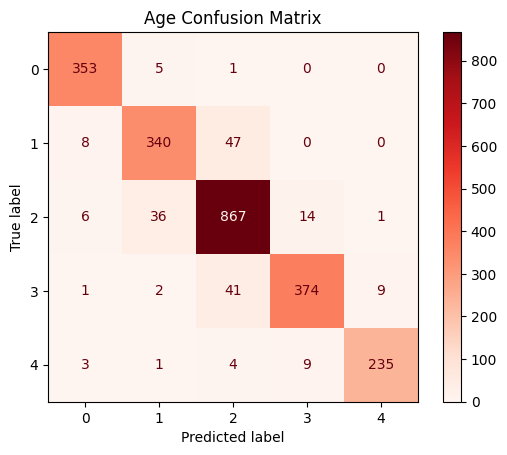

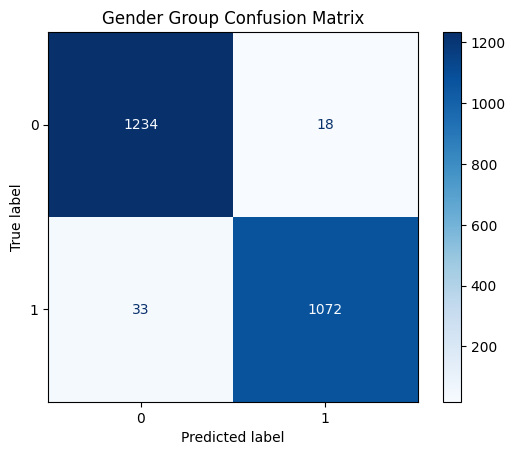

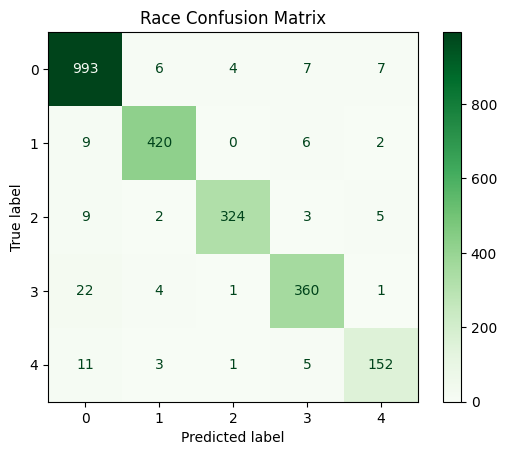

In [ ]:
# Plot confusion matrices
def plot_confusion_matrix(predicted_labels, true_labels, classes, cmap, title):
    y_pred= [label for label in predicted_labels]
    y_true = [label for label in true_labels]
    classes = np.arange(classes)
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=cmap)
    plt.title(title)
    plt.show()


# Gender confusion matrix
plot_confusion_matrix(predicted_age, true_age, classes = 5, cmap = 'Reds', title = "Age Confusion Matrix")

# Age confusion matrix
plot_confusion_matrix(predicted_gender, true_gender, classes = 2, cmap ='Blues', title = "Gender Group Confusion Matrix")

# Race confusion matrix
plot_confusion_matrix(predicted_race, true_race, classes = 5, cmap ='Greens', title = "Race Confusion Matrix")

### Classification report

In [ ]:
age_labels = ["0-14", "14-25", "25-40", "40-60", "60+"]
gender_labels = ["Male", "Female"]
race_labels = ["White", "Black", "Asian", "Indian", "Others"]

# Generate classification reports for each task
age_report = classification_report(true_age, predicted_age, target_names=age_labels)
gender_report = classification_report(true_gender, predicted_gender, target_names=gender_labels)
race_report = classification_report(true_race, predicted_race, target_names=race_labels)

print("\nClassification Report for Age Group:")
print(age_report)

# Print the reports
print("\nClassification Report for Gender:")
print(gender_report)

print("\nClassification Report for Race:")
print(race_report)


Classification Report for Age Group:
              precision    recall  f1-score   support

        0-14       0.95      0.98      0.97       359
       14-25       0.89      0.86      0.87       395
       25-40       0.90      0.94      0.92       924
       40-60       0.94      0.88      0.91       427
         60+       0.96      0.93      0.95       252

    accuracy                           0.92      2357
   macro avg       0.93      0.92      0.92      2357
weighted avg       0.92      0.92      0.92      2357


Classification Report for Gender:
              precision    recall  f1-score   support

        Male       0.97      0.99      0.98      1252
      Female       0.98      0.97      0.98      1105

    accuracy                           0.98      2357
   macro avg       0.98      0.98      0.98      2357
weighted avg       0.98      0.98      0.98      2357


Classification Report for Race:
              precision    recall  f1-score   support

       White       0.95